In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')

In [3]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

In [4]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
occlusion_pseudopop_responses = {}

for area in areanames:
    #For oddball block
    X_occlusion, stimulus_df = dc.create_psuedopopulation(manifest, area, block='occlusion')
    occlusion_pseudopop_responses[area] = [X_occlusion, stimulus_df]

/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/dwyrick/miniconda3/envs/ainp/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


RSP pseudopopulation created for the occlusion block: 1628 neurons from 12 experiments
VISp pseudopopulation created for the occlusion block: 2299 neurons from 15 experiments
VISpm pseudopopulation created for the occlusion block: 2071 neurons from 22 experiments


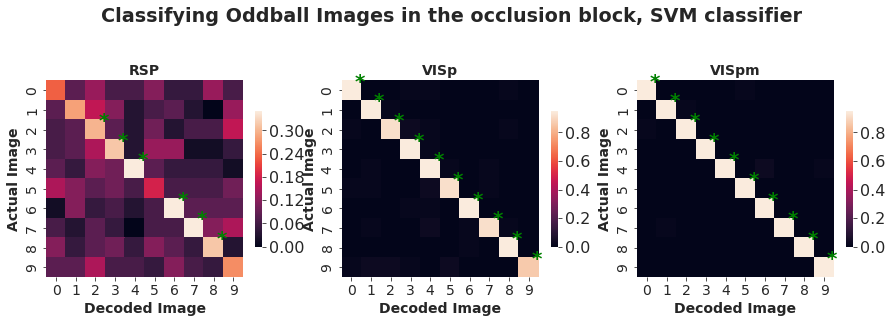

In [20]:
classifier = 'SVM'
method='kfold'
fig, axes = plt.subplots(1,3,figsize=(15,5))
for ii,area in enumerate(areanames):
    X_occlusion = occlusion_pseudopop_responses[area][0]
    stimulus_df = occlusion_pseudopop_responses[area][1]
    
    #Get trials for occlusion block
    stimIDs = stimulus_df.loc[stimulus_df['session_block_name'] == 'occlusion'].index.values
    Y_occlusion = stimulus_df.loc[stimIDs]['image_id'].values
    Y_sort = np.array(['{}/{}'.format(stimulus_df.loc[sID]['image_id'],stimulus_df.loc[sID]['fraction_occlusion']) for sID in stimIDs])

    #Use pseudopopulation vectors for decoding
    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_occlusion, Y_occlusion, Y_sort, method=method,classifier=classifier,plot_shuffle=False,clabels=oddball_ids)

    fpath = os.path.join(SaveDir,'Ximg_decoding_occlusion-block_{}_{}.mat'.format(area,classifier))
    with h5py.File(fpath,'w') as h5file:
        h5file.create_dataset('confusion_mat',data=confusion_mat)
        h5file.create_dataset('confusion_shf',data=confusion_shf)
        h5file.create_dataset('confusion_z',data=confusion_z)
        h5file.create_dataset('area',data=area)
        h5file.create_dataset('classifier',data=classifier)
        h5file.create_dataset('method',data=method)

    dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=area,annot=False)
plt.suptitle('Classifying Oddball Images in the occlusion block, {} classifier'.format(classifier))
plt.savefig(os.path.join(PlotDir,'Ximg_decoding_occlusion-block_{}.png'.format(classifier)))

low
med
high


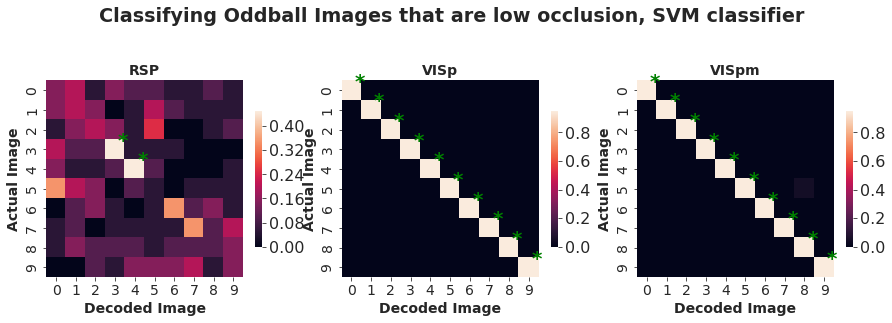

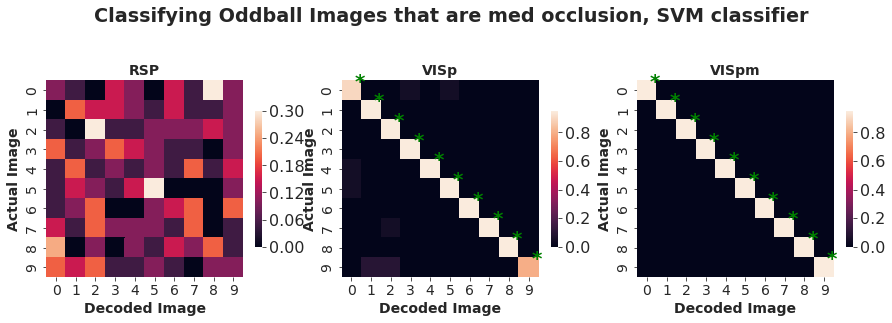

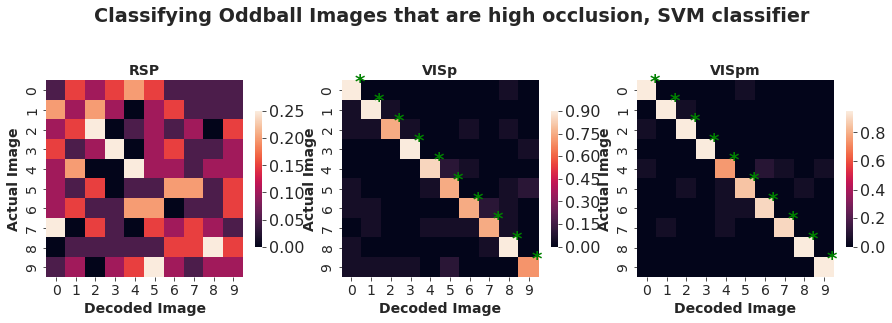

In [27]:
classifier = 'SVM'
method='kfold'

for occl_fracs,occl_str in zip([[0, 0.15], [0.3, 0.4], [0.5, 0.6]],['low','med','high']):
    print(occl_str)
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for ii,area in enumerate(areanames):
        X_occlusion = occlusion_pseudopop_responses[area][0]
        stimulus_df = occlusion_pseudopop_responses[area][1]

        #Get trials for occlusion block
        stimIDs = stimulus_df.loc[(stimulus_df['session_block_name'] == 'occlusion') & (stimulus_df['fraction_occlusion'].isin(occl_fracs))].index.values
        X_occlusion = X_occlusion.loc[stimIDs]
        Y_occlusion = stimulus_df.loc[stimIDs]['image_id'].values
#         Y_sort = stimulus_df.loc[stimIDs]['image_id'].values
        Y_sort = np.array(['{}/{}'.format(stimulus_df.loc[sID]['image_id'],stimulus_df.loc[sID]['fraction_occlusion']) for sID in stimIDs])
#         pdb.set_trace()
        #Use pseudopopulation vectors for decoding
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_occlusion, Y_occlusion, Y_sort, method=method,classifier=classifier,plot_shuffle=False,clabels=oddball_ids)
        
        fpath = os.path.join(SaveDir,'Ximg_decoding_occlusion-block_{}-occl_{}_{}.mat'.format(occl_str,area,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat',data=confusion_mat)
            h5file.create_dataset('confusion_shf',data=confusion_shf)
            h5file.create_dataset('confusion_z',data=confusion_z)
            h5file.create_dataset('area',data=area)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        dc.plot_decoding_accuracy(confusion_mat,confusion_z,ax=axes[ii],class_labels=np.arange(10),title=area,annot=False)
    plt.suptitle('Classifying Oddball Images that are {} occlusion, {} classifier'.format(occl_str,classifier))
    plt.savefig(os.path.join(PlotDir,'Ximg_decoding_occlusion-block_{}-occl_{}.png'.format(occl_str,classifier)))